In [2]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat, umath, unumpy

In [3]:
# Settings + Notes
"""The units used are in SI units."""

# Plotting Settings
plt.style.use("default")

# # remove interactive mode
# plt.ioff()

# # disable images from automatically showing up
# use("Agg")

In [4]:
# Equations

/home/divy/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


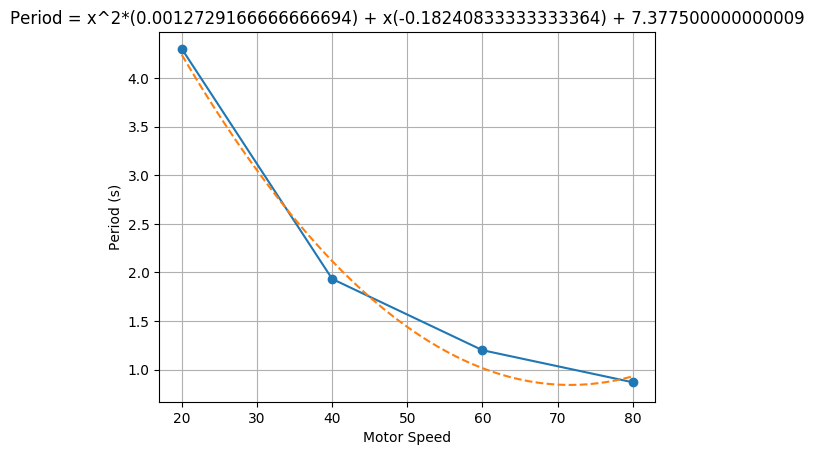

In [5]:
# Deriving a relationship between motor speed and period.
motorSpeed = [i for i in range(20, 100, 20)]
# print(motorSpeed)
periods = [4.3, 5.8/3, 6.0/5, 8.7/10]
# print(periods)

z = np.polyfit(motorSpeed, periods, deg=2)
# generate line of best fit
p = np.poly1d(z)
xp = np.linspace(min(motorSpeed), max(motorSpeed), 100)

# plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Motor Speed")
ax.set_ylabel("Period (s)")
ax.grid(True)
ax.set_title("Period = x^2*({}) + x({}) + {}".format(z[0], z[1], z[2]))
ax.plot(motorSpeed, periods, "-o")
ax.plot( xp, p(xp), "--")
# show figure
fig.show()

In [0]:
# Question 1: Determining c_0

distance = ufloat(1.8, 0.05)  # meters
times = [2.2, 1.8, 2.4, 1.9, 1.9, 1.9]
# update times to include uncertainty
for _ in range(len(times)):
    times.append(ufloat(times.pop(0), 0.1)) # seconds
# calculate average c_0 value
averageTime = sum(times)/len(times)
C0 = distance/averageTime

